## Regression: Hyundai Heavy Industry Cruise ship data
http://www.hyundai.eu

** Dataset Information: **

Measurements of ship size, capacity, crew, and age for 158 cruise ships

** Attribute Information: **

- Ship Name     1-20
- Cruise Line   21-40
- Age (as of 2013)   46-48
- Tonnage (1000s of tons)   50-56
- passengers (100s)   58-64
- Length (100s of feet)  66-72
- Cabins  (100s)   74-80
- Passenger Density   82-88
- Crew  (100s)   90-96

** Objective of this project **

predict how many crew members will be needed for future ships

## Data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
# Load Data
df = pd.read_csv('cruise_ship_info.csv')

In [3]:
# Inspect Data
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [4]:
df.shape

(158, 9)

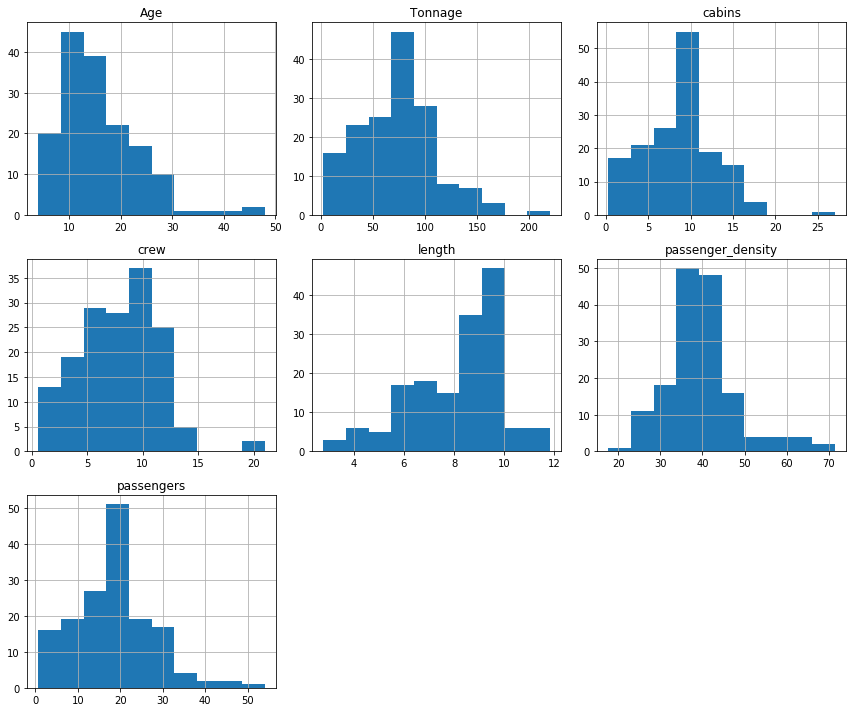

In [5]:
_ = df.hist(figsize=(12,10))
plt.tight_layout()

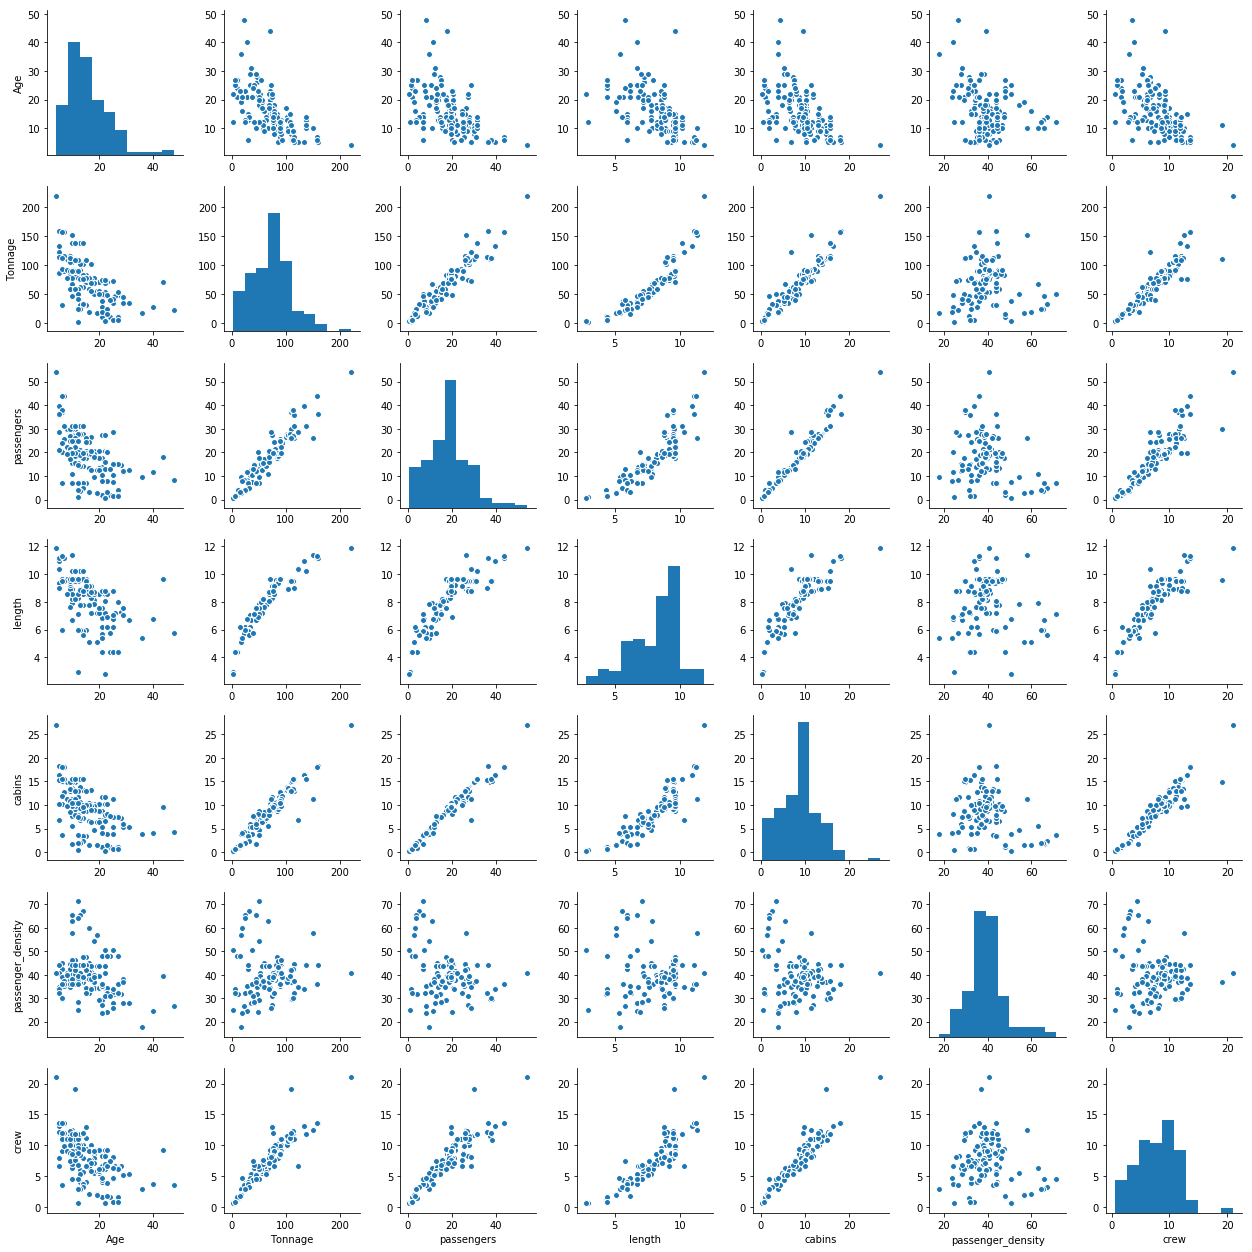

In [6]:
sns.pairplot(df, size=2.5)
plt.tight_layout()

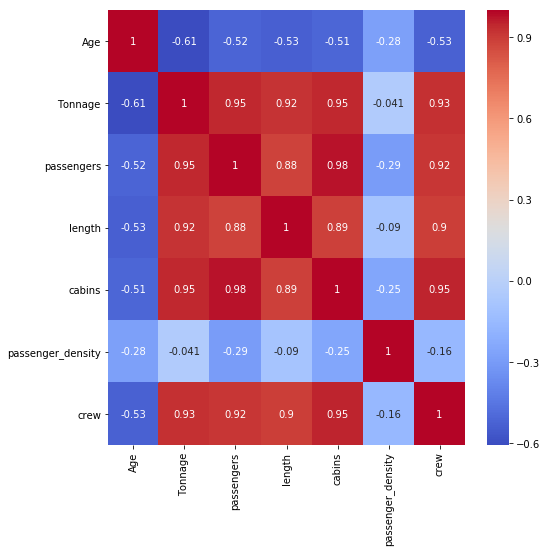

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
Ship_name            158 non-null object
Cruise_line          158 non-null object
Age                  158 non-null int64
Tonnage              158 non-null float64
passengers           158 non-null float64
length               158 non-null float64
cabins               158 non-null float64
passenger_density    158 non-null float64
crew                 158 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [9]:
df.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [10]:
df.isnull().any()

Ship_name            False
Cruise_line          False
Age                  False
Tonnage              False
passengers           False
length               False
cabins               False
passenger_density    False
crew                 False
dtype: bool

## Data preprocessing

In [11]:
seed = 101 #random seed for reproducibility
np.random.seed(seed)

** Split Features & Class (or target) **

In [12]:
df.drop(['Ship_name','Cruise_line'], axis=1, inplace=True)
X = df.drop('crew', axis=1).values
y = df['crew'].values
print(X.shape,y.shape)

(158, 6) (158,)


** Split Train Test Sets **

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(126, 6) (32, 6) (126,) (32,)


** Scale Features **

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

## Baseline Models

In [15]:
# Import libraries
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [16]:
models = []
#linear
models.append(('LR', LinearRegression()))
models.append(('RG', Ridge(random_state=seed)))
models.append(('LS', Lasso(random_state=seed)))
#non-linear
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor(random_state=seed)))
models.append(('SVM', SVR()))
#ensemble
models.append(('RF', RandomForestRegressor(n_estimators=100,random_state=seed)))
models.append(('XGB', XGBRegressor(random_state=seed)))

Model	MSE: mean (std)
LR	-1.048 (1.191)
RG	-1.038 (1.230)
LS	-2.368 (1.776)
KNN	-2.162 (2.064)
DT	-2.687 (1.959)
SVM	-3.123 (4.490)
RF	-1.670 (1.726)
XGB	-1.965 (1.620)


Text(0,0.5,'MSE')

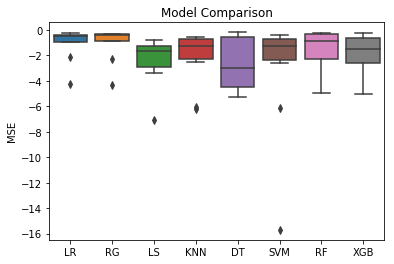

In [17]:
# cross validation
np.random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
scoring='neg_mean_squared_error'
names = []
results = []
print('Model\tMSE: mean (std)')
for name,model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)  
    results.append(cv_results)
    names.append(name)    
    print('{}\t{:0.3f} ({:0.3f})'.format(name, cv_results.mean(), cv_results.std()))

# visualize results
ax = sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.title('Model Comparison')
plt.ylabel('MSE')

## Parameter Tuning
Top 4 algorithms: RG,LR,RF,XGB

In [18]:
# define functions for grid search
def default_model_perfomance(model):
    cv = cross_val_score(model, X_train, y_train,cv=kfold, scoring=scoring)
    print(model.get_params())
    print('\nMSE of train set: {:0.3f} ({:0.3f})'.format(cv.mean(), cv.std()))

def best_model_performance(model,param_grid):
    # grid search
    np.random.seed(seed)
    scoring='neg_mean_squared_error'
    kfold = KFold(n_splits=10, random_state=seed)
    grid_search = GridSearchCV(model, param_grid=param_grid,cv=kfold, verbose=1, scoring=scoring)
    grid_result = grid_search.fit(X_train,y_train)

    # results
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%.3f (%.3f) with: %r" % (mean, stdev, param))

    # best
    print("\nBest MSE of train set: {:0.3f} using {}".format(grid_result.best_score_,grid_result.best_params_))

#### Model 1: Ridge Regression

In [19]:
# Default
model = Ridge(random_state=seed)
default_model_perfomance(model)

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': 101, 'solver': 'auto', 'tol': 0.001}

MSE of train set: -1.038 (1.230)


In [20]:
# Grid Search
model = Ridge(random_state=seed)
alpha = [10,1,0.1,0.001]
param_grid = dict(alpha=alpha)
best_model_performance(model,param_grid)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
-1.222 (1.367) with: {'alpha': 10}
-1.041 (1.241) with: {'alpha': 1}
-1.045 (1.208) with: {'alpha': 0.1}
-1.052 (1.202) with: {'alpha': 0.001}

Best MSE of train set: -1.041 using {'alpha': 1}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


#### Model 2: Linear Regression

In [21]:
# Default --> no tuning params
model = LinearRegression()
default_model_perfomance(model)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

MSE of train set: -1.048 (1.191)


#### Model 3: Random Forest

In [22]:
# Default
model = RandomForestRegressor(n_estimators=100,random_state=seed)
default_model_perfomance(model)

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 101, 'verbose': 0, 'warm_start': False}

MSE of train set: -1.670 (1.726)


In [23]:
# Grid Search
model = RandomForestRegressor(random_state=seed)
n_estimators = [50,100,150,200]
max_depth = [2,4,6]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
best_model_performance(model,param_grid)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
-2.180 (2.088) with: {'max_depth': 2, 'n_estimators': 50}
-2.176 (2.054) with: {'max_depth': 2, 'n_estimators': 100}
-2.150 (2.000) with: {'max_depth': 2, 'n_estimators': 150}
-2.143 (2.005) with: {'max_depth': 2, 'n_estimators': 200}
-1.771 (1.751) with: {'max_depth': 4, 'n_estimators': 50}
-1.773 (1.799) with: {'max_depth': 4, 'n_estimators': 100}
-1.753 (1.779) with: {'max_depth': 4, 'n_estimators': 150}
-1.757 (1.772) with: {'max_depth': 4, 'n_estimators': 200}
-1.698 (1.691) with: {'max_depth': 6, 'n_estimators': 50}
-1.698 (1.734) with: {'max_depth': 6, 'n_estimators': 100}
-1.667 (1.700) with: {'max_depth': 6, 'n_estimators': 150}
-1.671 (1.707) with: {'max_depth': 6, 'n_estimators': 200}

Best MSE of train set: -1.667 using {'max_depth': 6, 'n_estimators': 150}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   14.8s finished


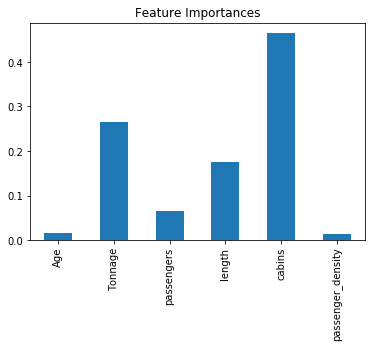

In [24]:
# Feature Importance
model = RandomForestRegressor(max_depth=6,n_estimators=150,random_state=seed)
model.fit(X_train, y_train)
pd.DataFrame(data=model.feature_importances_,
             index=df.drop('crew',axis=1).columns).plot(kind='bar',legend=False,
                                                        title='Feature Importances')

#### Model 4: XGBoost

In [25]:
# Default
model = XGBRegressor(n_estimators=100,random_state=seed)
default_model_perfomance(model)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 101, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}

MSE of train set: -1.965 (1.620)


In [26]:
# Grid Search
model = XGBRegressor(random_state=seed)
n_estimators = [100, 200, 300]
max_depth = [2,4,6]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
best_model_performance(model,param_grid)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
-1.831 (1.710) with: {'max_depth': 2, 'n_estimators': 100}
-1.918 (1.741) with: {'max_depth': 2, 'n_estimators': 200}
-1.949 (1.774) with: {'max_depth': 2, 'n_estimators': 300}
-2.067 (1.732) with: {'max_depth': 4, 'n_estimators': 100}
-2.073 (1.703) with: {'max_depth': 4, 'n_estimators': 200}
-2.076 (1.700) with: {'max_depth': 4, 'n_estimators': 300}
-2.179 (2.076) with: {'max_depth': 6, 'n_estimators': 100}
-2.203 (2.089) with: {'max_depth': 6, 'n_estimators': 200}
-2.204 (2.089) with: {'max_depth': 6, 'n_estimators': 300}

Best MSE of train set: -1.831 using {'max_depth': 2, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.8s finished


[ 0.16254418  0.18021202  0.14840989  0.19787987  0.22968198  0.08127209]


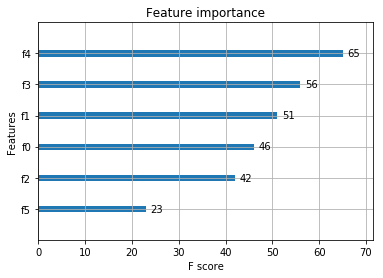

In [27]:
# Feature Importance
from xgboost import plot_importance  
model = XGBRegressor(max_depth=2, n_estimators=100, random_state=seed)                      
model.fit(X_train,y_train)
print(model.feature_importances_)
plot_importance(model)

## Final Model: Ridge Regression

** Params: alpha=1.0 **

In [28]:
from sklearn.pipeline import Pipeline

# prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# create a pipeline
final_model = Pipeline([('scaler', StandardScaler()), #scale
                        ('regressor', Ridge(alpha=1.0,random_state=seed))]) #regressor          
# train model
final_model.fit(X_train, y_train)
print('MSE of train set: {:0.3f}'.format(mean_squared_error(y_train, final_model.predict(X_train))))
print('R^2 of train set: {:0.3f}'.format(r2_score(y_train, final_model.predict(X_train))))

MSE of train set: 0.938
R^2 of train set: 0.920


** Save and load the final model **

In [29]:
#save model to disk
import pickle
filename='model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [30]:
#load the model from disk
model = pickle.load(open(filename,'rb'))
print('MSE of train set: {:0.3f}'.format(mean_squared_error(y_train, final_model.predict(X_train))))
print('R^2 of train set: {:0.3f}'.format(r2_score(y_train, final_model.predict(X_train))))

MSE of train set: 0.938
R^2 of train set: 0.920


## Model Evaluation with Test set

In [31]:
# predict class with test set (new, unseen)
y_pred = final_model.predict(X_test)
print('MSE of test set: {:0.3f}'.format(mean_squared_error(y_test, final_model.predict(X_test))))
print('R^2 of test set: {:0.3f}'.format(r2_score(y_test, final_model.predict(X_test))))

MSE of test set: 0.924
R^2 of test set: 0.933


(0, 14)

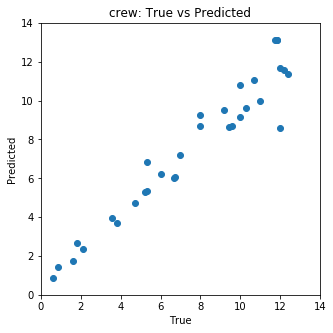

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred)
plt.title('crew: True vs Predicted')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0,14])
plt.ylim([0,14])

(0, 4.5)

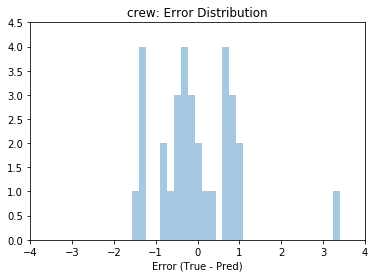

In [36]:
sns.distplot(y_test-y_pred, bins=30, kde=False, axlabel='Error (True - Pred)')
plt.title('crew: Error Distribution')
plt.xlim([-4,4])
plt.ylim([0,4.5])

## Summary

Best model: ** Ridge Regression ** w/ alpha=0.1

MSE / RMSE / R2 of test set: ** 0.924, 0.961, 0.933 **